In [185]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn 
import scipy as sp
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

In [115]:
# check the current datasets shape and subdivision:


In [116]:
# Things I found out I need to know:
# How they load the data: they use load_data function defined in utils and split it into 
# train,validation and test sets

In [186]:
# braek down load_data function:
# 1: loading the raw data

suffix = '_springs5'

loc_train = np.load('data/loc_train' + suffix + '.npy')
vel_train = np.load('data/vel_train' + suffix + '.npy')
edges_train = np.load('data/edges_train' + suffix + '.npy')

loc_valid = np.load('data/loc_valid' + suffix + '.npy')
vel_valid = np.load('data/vel_valid' + suffix + '.npy')
edges_valid = np.load('data/edges_valid' + suffix + '.npy')

loc_test = np.load('data/loc_test' + suffix + '.npy')
vel_test = np.load('data/vel_test' + suffix + '.npy')
edges_test = np.load('data/edges_test' + suffix + '.npy')

In [187]:
print(loc_train.shape)
print(loc_valid.shape)
print(loc_test.shape)

# 2500 samples, 49 timesteps, x & y positions for 5 particles

(2500, 49, 2, 5)
(1000, 49, 2, 5)
(1000, 99, 2, 5)


In [121]:
# for SLEAP, we have:
# 1 sample, 63033 frames, x & y positions for 2 mice

In [188]:
vel_train.shape

(2500, 49, 2, 5)

In [189]:
edges_train.shape

(2500, 5, 5)

In [190]:
edges_train[0,:,:]

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [191]:
edges_test.shape

(1000, 5, 5)

In [192]:
type(edges_train)

numpy.ndarray

In [193]:
edges_train[0,0,4]

np.float64(1.0)

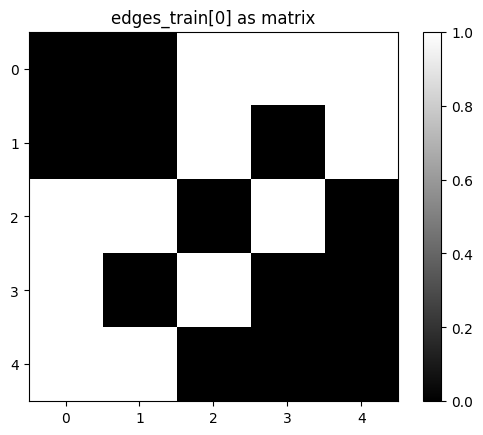

In [194]:
plt.imshow(edges_train[2], cmap='gray')
plt.title("edges_train[0] as matrix")
plt.colorbar()
plt.show()

In [195]:
#2: preprocessing it
   # [num_samples, num_timesteps, num_dims, num_atoms]
num_atoms = loc_train.shape[3]

loc_max = loc_train.max()
loc_min = loc_train.min()
vel_max = vel_train.max()
vel_min = vel_train.min()

# Normalize to [-1, 1]
loc_train = (loc_train - loc_min) * 2 / (loc_max - loc_min) - 1
vel_train = (vel_train - vel_min) * 2 / (vel_max - vel_min) - 1

loc_valid = (loc_valid - loc_min) * 2 / (loc_max - loc_min) - 1
vel_valid = (vel_valid - vel_min) * 2 / (vel_max - vel_min) - 1

loc_test = (loc_test - loc_min) * 2 / (loc_max - loc_min) - 1
vel_test = (vel_test - vel_min) * 2 / (vel_max - vel_min) - 1

# Reshape to: [num_sims, num_atoms, num_timesteps, num_dims]
loc_train = np.transpose(loc_train, [0, 3, 1, 2])
vel_train = np.transpose(vel_train, [0, 3, 1, 2])
feat_train = np.concatenate([loc_train, vel_train], axis=3)
edges_train = np.reshape(edges_train, [-1, num_atoms ** 2])
edges_train = np.array((edges_train + 1) / 2, dtype=np.int64)

loc_valid = np.transpose(loc_valid, [0, 3, 1, 2])
vel_valid = np.transpose(vel_valid, [0, 3, 1, 2])
feat_valid = np.concatenate([loc_valid, vel_valid], axis=3)
edges_valid = np.reshape(edges_valid, [-1, num_atoms ** 2])
edges_valid = np.array((edges_valid + 1) / 2, dtype=np.int64)

loc_test = np.transpose(loc_test, [0, 3, 1, 2])
vel_test = np.transpose(vel_test, [0, 3, 1, 2])
feat_test = np.concatenate([loc_test, vel_test], axis=3)
edges_test = np.reshape(edges_test, [-1, num_atoms ** 2])
edges_test = np.array((edges_test + 1) / 2, dtype=np.int64)

feat_train = torch.FloatTensor(feat_train)
edges_train = torch.LongTensor(edges_train)
feat_valid = torch.FloatTensor(feat_valid)
edges_valid = torch.LongTensor(edges_valid)
feat_test = torch.FloatTensor(feat_test)
edges_test = torch.LongTensor(edges_test)

In [196]:
edges_train[0,0]

tensor(0)

In [197]:
loc_train.shape

(2500, 5, 49, 2)

In [198]:
edges_train.shape

torch.Size([2500, 25])

In [199]:
# Exclude self edges: np.eye is diagonal matrix of ones, np.ravel..
# converts 2D indices to 1D flattened indices  suitable for indexing
# the flattened matrices edges_train etc.
off_diag_idx = np.ravel_multi_index(
    np.where(np.ones((num_atoms, num_atoms)) - np.eye(num_atoms)),
[num_atoms, num_atoms])
edges_train = edges_train[:, off_diag_idx]
edges_valid = edges_valid[:, off_diag_idx]
edges_test = edges_test[:, off_diag_idx]

In [216]:
edges_train.shape

torch.Size([2500, 20])

In [200]:
# then convert them into tensor datasets and
# wraps the datasets to allow batching, parallel loading etc.

batch_size = 64

train_data = TensorDataset(feat_train, edges_train)
valid_data = TensorDataset(feat_valid, edges_valid)
test_data = TensorDataset(feat_test, edges_test)

train_data_loader = DataLoader(train_data, batch_size=batch_size)
valid_data_loader = DataLoader(valid_data, batch_size=batch_size)
test_data_loader = DataLoader(test_data, batch_size=batch_size)


In [201]:
train_data.__annotations__

{'tensors': tuple[torch.Tensor, ...]}

In [202]:
train_data_loader.__class__

torch.utils.data.dataloader.DataLoader

In [215]:
train_data_loader.__sizeof__

<function DataLoader.__sizeof__()>

In [203]:
edges_train[0,8]

tensor(0)

In [204]:
# ok so for the SLEAP data we have loc, vel but how and where do we get edges from?
# we can start with assumptions - assume both mice are interacting with each other so 2,2 
# matrix with 1s on off diagonal for each of the 1 sample? we have

In [205]:
# something to note here: 
    # 1. so we have similar data except instead of 5 atoms, we have 2 mice
    # 2. we also have only one sample? so far instead of 2500 like in the springs dataset
        # ok so even if we have only 2 mice we can still use NRI as a proof of concept 
        # to see if it works and to explicity model pairwaise interactions

In [206]:
# make raw dataset from SLEAP data to be passed into the load_data function:

# training timesteps: 1-20k
# valid timesteps: 39k -45k
# test timesteps: 45k - 51k


# check if you can use the function generate dataset to do this part

In [207]:
locations = np.load('thorax_locations.npy')
locations.shape

(63033, 2, 2)

In [208]:
# reshpa the data to
locations = np.reshape(locations, (1,63033,2,2))
locations.shape

(1, 63033, 2, 2)

In [209]:
# load velocities
velocities = np.load('velocities.npy')
velocities.shape

(63033, 2, 2)

In [210]:
# reshape velocities
velocities = np.reshape(velocities, (1,63033,2,2))
velocities.shape

(1, 63033, 2, 2)

In [211]:
# split into train, valid, test
locations_train = locations[:,:20000,:,:]
locations_valid = locations[:,39000:45000,:,:]
locations_test = locations[:,45000:51000,:,:]

In [212]:
velocities_train = velocities[:,:20000,:,:]
velocities_valid = velocities[:,39000:45000,:,:]
velocities_test = velocities[:,45000:51000,:,:]

In [213]:
velocities_valid.shape

(1, 6000, 2, 2)